In [2]:
import numpy
import matplotlib.pyplot as plt

from utils.dataset import load_iris_dataset
import utils.helpers as helpers

In [49]:
def split_db_2to1(D, L, seed=42):
    
    nTrain = int(D.shape[1]*2.0/3.0)
    numpy.random.seed(seed)
    idx = numpy.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    
    return (DTR, LTR), (DVAL, LVAL)

In [50]:
DIris, LIris = load_iris_dataset()
D = DIris[:, LIris != 0]
L = LIris[LIris != 0]
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)

In [51]:
print(DTR.shape, LTR.shape)
print(DVAL.shape, LVAL.shape)

(4, 66) (66,)
(4, 34) (34,)


In [52]:
m = 2
UPCA = helpers.compute_pca(DTR, m = m) # Estimated only on model training data
DTR_pca = helpers.apply_pca(UPCA, DTR)   # Applied to original model training data
DVAL_pca = helpers.apply_pca(UPCA, DVAL) # Applied to original validation data

In [53]:
ULDA = helpers.compute_lda_JointDiag(DTR_pca, LTR, m = 1) # Estimated only on model training data, after PCA has been applied

DTR_lda = helpers.apply_lda(ULDA, DTR_pca)   # Applied to PCA-transformed model training data, the projected training samples are required to check the orientation of the direction and to compute the threshold
# Check if the Virginica class samples are, on average, on the right of the Versicolor samples on the training set. If not, we reverse ULDA and re-apply the transformation
if DTR_lda[0, LTR==1].mean() > DTR_lda[0, LTR==2].mean():
    ULDA = -ULDA
    DTR_lda = helpers.apply_lda(ULDA, DTR_pca)
    
DVAL_lda = helpers.apply_lda(ULDA, DVAL_pca) # Applied to PCA-transformed validation data

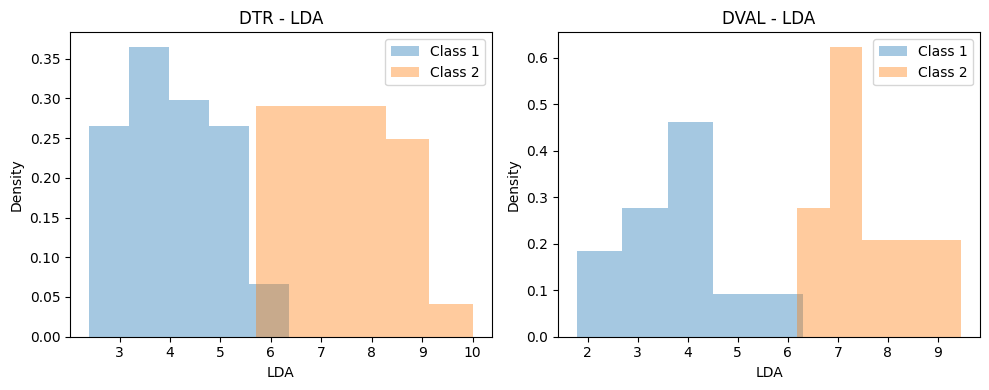

In [54]:
plt.figure(figsize=(10, 4))

# --- Training set ---
plt.subplot(1, 2, 1)
for label in [1, 2]:
    plt.hist(DTR_lda[0, LTR == label], bins=5, alpha=0.4, density=True, label=f"Class {label}")
plt.title("DTR - LDA")
plt.xlabel("LDA")
plt.ylabel("Density")
plt.legend()

# --- Validation set ---
plt.subplot(1, 2, 2)
for label in [1, 2]:
    plt.hist(DVAL_lda[0, LVAL == label], bins=5, alpha=0.4, density=True, label=f"Class {label}")
plt.title("DVAL - LDA")
plt.xlabel("LDA")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
threshold = (DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0 # Estimated only on model training data

PVAL = numpy.zeros(shape=LVAL.shape, dtype=numpy.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.1f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))


Labels:      [1 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1 1 1 2 1 1 1 2 2 2 2 2 1 2 2 1 2 2]
Predictions: [1 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 1 2 2]
Number of erros: 1 (out of 34 samples)
Error rate: 2.9%


In [6]:
# Solution without PCA pre-processing and threshold selection. The threshold is chosen half-way between the two classes
ULDA = helpers.compute_lda_JointDiag(DTR, LTR, m=1)

DTR_lda = helpers.apply_lda(ULDA, DTR)

# Check if the Virginica class samples are, on average, on the right of the Versicolor samples on the training set. If not, we reverse ULDA and re-apply the transformation.
if DTR_lda[0, LTR==1].mean() > DTR_lda[0, LTR==2].mean():
    ULDA = -ULDA
    DTR_lda = helpers.apply_lda(ULDA, DTR)

DVAL_lda  = helpers.apply_lda(ULDA, DVAL)

threshold = (DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0 # Estimated only on model training data

PVAL = numpy.zeros(shape=LVAL.shape, dtype=numpy.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.1f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))

Labels:      [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 2 1 1]
Predictions: [1 2 1 2 1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]
Number of erros: 2 (out of 34 samples)
Error rate: 5.9%


In [7]:
# Solution with PCA pre-processing with dimension m.
m = 2
UPCA = helpers.compute_pca(DTR, m = m) # Estimated only on model training data
DTR_pca = helpers.apply_pca(UPCA, DTR)   # Applied to original model training data
DVAL_pca = helpers.apply_pca(UPCA, DVAL) # Applied to original validation data

ULDA = helpers.compute_lda_JointDiag(DTR_pca, LTR, m = 1) # Estimated only on model training data, after PCA has been applied

DTR_lda = helpers.apply_lda(ULDA, DTR_pca)   # Applied to PCA-transformed model training data, the projected training samples are required to check the orientation of the direction and to compute the threshold
# Check if the Virginica class samples are, on average, on the right of the Versicolor samples on the training set. If not, we reverse ULDA and re-apply the transformation
if DTR_lda[0, LTR==1].mean() > DTR_lda[0, LTR==2].mean():
    ULDA = -ULDA
    DTR_lda = helpers.apply_lda(ULDA, DTR_pca)

DVAL_lda = helpers.apply_lda(ULDA, DVAL_pca) # Applied to PCA-transformed validation data

threshold = (DTR_lda[0, LTR==1].mean() + DTR_lda[0, LTR==2].mean()) / 2.0 # Estimated only on model training data

PVAL = numpy.zeros(shape=LVAL.shape, dtype=numpy.int32)
PVAL[DVAL_lda[0] >= threshold] = 2
PVAL[DVAL_lda[0] < threshold] = 1
print('Labels:     ', LVAL)
print('Predictions:', PVAL)
print('Number of erros:', (PVAL != LVAL).sum(), '(out of %d samples)' % (LVAL.size))
print('Error rate: %.1f%%' % ( (PVAL != LVAL).sum() / float(LVAL.size) *100 ))



Labels:      [1 2 1 2 1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 2 1 2 2 2 1 1]
Predictions: [1 2 1 2 1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 1 1]
Number of erros: 2 (out of 34 samples)
Error rate: 5.9%
